# Superstore Retail Data - Exploratory Data Analysis (EDA)

This notebook performs a comprehensive EDA of a retail superstore dataset, from basic profiling to advanced analyses with feature engineering.

- Data loading and initial inspection
- Cleaning and type casting
- Feature engineering (dates, ratios, profitability, customer features)
- Univariate and bivariate analysis
- Time series and categorical trends
- Advanced EDA: correlation, RFM, and cohort analysis
- Conclusions

Note: The notebook auto-detects a suitable dataset file in the working directory (CSV/XLSX).


In [1]:
# Imports
import os
import re
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', context='notebook')

# Display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

# Helper: detect dataset file
SUPPORTED_EXTS = ('.csv', '.xlsx', '.xls')
CANDIDATE_KEYWORDS = ['super', 'store', 'retail', 'orders', 'sales']

workspace = Path('.')
files = list(workspace.glob('*'))


def score_file(p: Path) -> int:
    if not p.is_file():
        return -1
    score = 0
    if p.suffix.lower() in SUPPORTED_EXTS:
        score += 5
    name = p.name.lower()
    for kw in CANDIDATE_KEYWORDS:
        if kw in name:
            score += 2
    # Prefer non-temporary files
    if name.startswith('~$'):
        score -= 10
    # Prefer non-zip for immediate loading
    if p.suffix.lower() == '.zip':
        score -= 5
    return score

candidates = sorted(files, key=score_file, reverse=True)

print('Detected candidate data files (top 5):')
for p in candidates[:5]:
    print('-', p.name)

# Choose first good candidate
chosen = None
for p in candidates:
    if p.suffix.lower() in SUPPORTED_EXTS and not p.name.startswith('~$'):
        chosen = p
        break

print('\nChosen dataset file:', chosen.name if chosen else 'None found')


Detected candidate data files (top 5):
- 1719219914-Analysis of Super Store - DA (1).csv
- Attrition_Analytics.csv
- data for EDA.xlsx
- sample_cleaned.csv
- EDA_superstore.ipynb

Chosen dataset file: 1719219914-Analysis of Super Store - DA (1).csv


In [2]:
# Load dataset
if chosen is None:
    raise FileNotFoundError("No suitable dataset found in working directory. Please place a CSV/XLSX file.")

if chosen.suffix.lower() == '.csv':
    df_raw = pd.read_csv(chosen)
elif chosen.suffix.lower() in ('.xlsx', '.xls'):
    # Try common sheet names, otherwise first sheet
    xls = pd.ExcelFile(chosen)
    sheet_name = None
    for cand in ['Orders', 'orders', 'Sheet1', 'Data', 'Superstore', 'Sales']:
        if cand in xls.sheet_names:
            sheet_name = cand
            break
    df_raw = pd.read_excel(chosen, sheet_name=sheet_name)
else:
    raise ValueError(f"Unsupported file type: {chosen.suffix}")

print(df_raw.shape)
df_raw.head()


(9994, 13)


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,2,0.00,41.91
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.94,3,0.00,219.58
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.62,2,0.00,6.87
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.58,5,0.45,-383.03
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.37,2,0.20,2.52


In [3]:
# Initial inspection
info_buf = []
df_raw.info(buf=sys.stdout)
print('\nMissing values per column:')
print(df_raw.isna().sum().sort_values(ascending=False).head(20))

print('\nBasic stats (numeric):')
df_raw.describe(include=[np.number]).T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     9994 non-null   object 
 1   Segment       9994 non-null   object 
 2   Country       9994 non-null   object 
 3   City          9994 non-null   object 
 4   State         9994 non-null   object 
 5   Postal Code   9994 non-null   int64  
 6   Region        9994 non-null   object 
 7   Category      9994 non-null   object 
 8   Sub-Category  9994 non-null   object 
 9   Sales         9994 non-null   float64
 10  Quantity      9994 non-null   int64  
 11  Discount      9994 non-null   float64
 12  Profit        9994 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 1015.1+ KB

Missing values per column:
Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Categor

,count,mean,std,min,25%,50%,75%,max
Postal Code,"9,994.00","55,190.38","32,063.69","1,040.00","23,223.00","56,430.50","90,008.00","99,301.00"
Sales,"9,994.00",229.86,623.25,0.44,17.28,54.49,209.94,"22,638.48"
Quantity,"9,994.00",3.79,2.23,1.00,2.00,3.00,5.00,14.00
Discount,"9,994.00",0.16,0.21,0.00,0.00,0.20,0.20,0.80
Profit,"9,994.00",28.66,234.26,"-6,599.98",1.73,8.67,29.36,"8,399.98"


In [4]:
# Basic value counts and unique checks for common retail fields
candidate_cols = df_raw.columns.str.lower()

possible_id_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ['order id', 'order_id', 'orderid'])]
possible_date_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ['date', 'order date', 'ship date'])]
possible_cust_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ['customer', 'cust'])]
possible_cat_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ['category', 'segment', 'region', 'state', 'city', 'sub-category'])]
possible_sales_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ['sales', 'revenue', 'amount'])]
possible_profit_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ['profit', 'margin'])]
possible_qty_cols = [c for c in df_raw.columns if any(k in c.lower() for k in ['quantity', 'qty'])]

summary = {
    'rows': len(df_raw),
    'cols': len(df_raw.columns),
    'id_cols': possible_id_cols,
    'date_cols': possible_date_cols,
    'customer_cols': possible_cust_cols,
    'category_cols': possible_cat_cols,
    'sales_cols': possible_sales_cols,
    'profit_cols': possible_profit_cols,
    'quantity_cols': possible_qty_cols,
}
summary


{'rows': 9994,
 'cols': 13,
 'id_cols': [],
 'date_cols': [],
 'customer_cols': [],
 'category_cols': ['Segment',
  'City',
  'State',
  'Region',
  'Category',
  'Sub-Category'],
 'sales_cols': ['Sales'],
 'profit_cols': ['Profit'],
 'quantity_cols': ['Quantity']}

In [5]:
# Cleaning and type casting

df = df_raw.copy()

# Strip column names
df.columns = [c.strip() for c in df.columns]

# Identify likely date columns and parse
for c in df.columns:
    cl = c.lower()
    if any(k in cl for k in ['date']):
        try:
            df[c] = pd.to_datetime(df[c])
        except Exception:
            pass

# Standardize categorical-like columns to string
cat_like_cols = []
for c in df.columns:
    if df[c].dtype == 'object' and df[c].nunique(dropna=True) < max(200, int(0.1 * len(df))):
        cat_like_cols.append(c)
        df[c] = df[c].astype(str).str.strip()

# Remove obvious duplicates
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Removed duplicates: {before - after}")

# Basic outlier clipping for negative sales/quantity if present
for c in df.columns:
    cl = c.lower()
    if any(k in cl for k in ['sales', 'revenue', 'amount']) and pd.api.types.is_numeric_dtype(df[c]):
        # clip extreme negatives to 0 if clearly wrong
        df[c] = df[c].clip(lower=0)
    if any(k in cl for k in ['quantity', 'qty']) and pd.api.types.is_numeric_dtype(df[c]):
        df[c] = df[c].clip(lower=0)

print('Done cleaning.')
df.head(3)


Removed duplicates: 17
Done cleaning.


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,2,0.00,41.91
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.94,3,0.00,219.58
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.62,2,0.00,6.87


In [6]:
# Feature engineering: standard retail fields

# Map common column names
def find_col(options):
    for opt in options:
        for c in df.columns:
            if opt.lower() == c.lower():
                return c
    return None

col_order_date = find_col(['Order Date', 'Order_Date', 'OrderDate', 'Order date']) or next((c for c in df.columns if 'order' in c.lower() and 'date' in c.lower()), None)
col_ship_date = find_col(['Ship Date', 'Ship_Date', 'ShipDate', 'Ship date']) or next((c for c in df.columns if 'ship' in c.lower() and 'date' in c.lower()), None)
col_sales = find_col(['Sales', 'sales', 'Revenue', 'Amount']) or next((c for c in df.columns if 'sales' in c.lower()), None)
col_profit = find_col(['Profit', 'profit', 'Margin']) or next((c for c in df.columns if 'profit' in c.lower() or 'margin' in c.lower()), None)
col_quantity = find_col(['Quantity', 'Qty', 'quantity']) or next((c for c in df.columns if 'qty' in c.lower() or 'quantity' in c.lower()), None)
col_discount = find_col(['Discount', 'discount']) or next((c for c in df.columns if 'discount' in c.lower()), None)
col_customer = find_col(['Customer Name', 'Customer', 'customer']) or next((c for c in df.columns if 'customer' in c.lower()), None)
col_category = find_col(['Category', 'category']) or next((c for c in df.columns if 'category' in c.lower()), None)
col_subcategory = find_col(['Sub-Category', 'SubCategory', 'Sub Category']) or next((c for c in df.columns if 'sub' in c.lower() and 'category' in c.lower()), None)
col_segment = find_col(['Segment', 'segment']) or next((c for c in df.columns if 'segment' in c.lower()), None)
col_state = find_col(['State', 'state']) or next((c for c in df.columns if 'state' in c.lower()), None)
col_city = find_col(['City', 'city']) or next((c for c in df.columns if 'city' in c.lower()), None)
col_region = find_col(['Region', 'region']) or next((c for c in df.columns if 'region' in c.lower()), None)

# Date parts
if col_order_date and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    df['order_year'] = df[col_order_date].dt.year
    df['order_month'] = df[col_order_date].dt.month
    df['order_day'] = df[col_order_date].dt.day
    df['order_week'] = df[col_order_date].dt.isocalendar().week.astype(int)
    df['order_quarter'] = df[col_order_date].dt.quarter
    df['order_ym'] = df[col_order_date].dt.to_period('M').astype(str)

# Profitability ratios
if col_sales and pd.api.types.is_numeric_dtype(df[col_sales]):
    if col_quantity and pd.api.types.is_numeric_dtype(df[col_quantity]):
        df['price_per_unit'] = np.where(df[col_quantity] > 0, df[col_sales] / df[col_quantity], np.nan)
    if col_discount and pd.api.types.is_numeric_dtype(df[col_discount]):
        df['discount_amount'] = df[col_sales] * df[col_discount]

if col_profit and pd.api.types.is_numeric_dtype(df[col_profit]) and col_sales and pd.api.types.is_numeric_dtype(df[col_sales]):
    df['profit_margin_pct'] = np.where(df[col_sales] != 0, df[col_profit] / df[col_sales] * 100, np.nan)

# RFM reference date
rfm_reference_date = None
if col_order_date and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    rfm_reference_date = df[col_order_date].max() + pd.Timedelta(days=1)

print('Engineered columns:', [c for c in df.columns if c not in df_raw.columns])
df.head(3)


Engineered columns: ['price_per_unit', 'discount_amount', 'profit_margin_pct']


,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,price_per_unit,discount_amount,profit_margin_pct
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.96,2,0.00,41.91,130.98,0.00,16.00
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.94,3,0.00,219.58,243.98,0.00,30.00
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.62,2,0.00,6.87,7.31,0.00,47.00


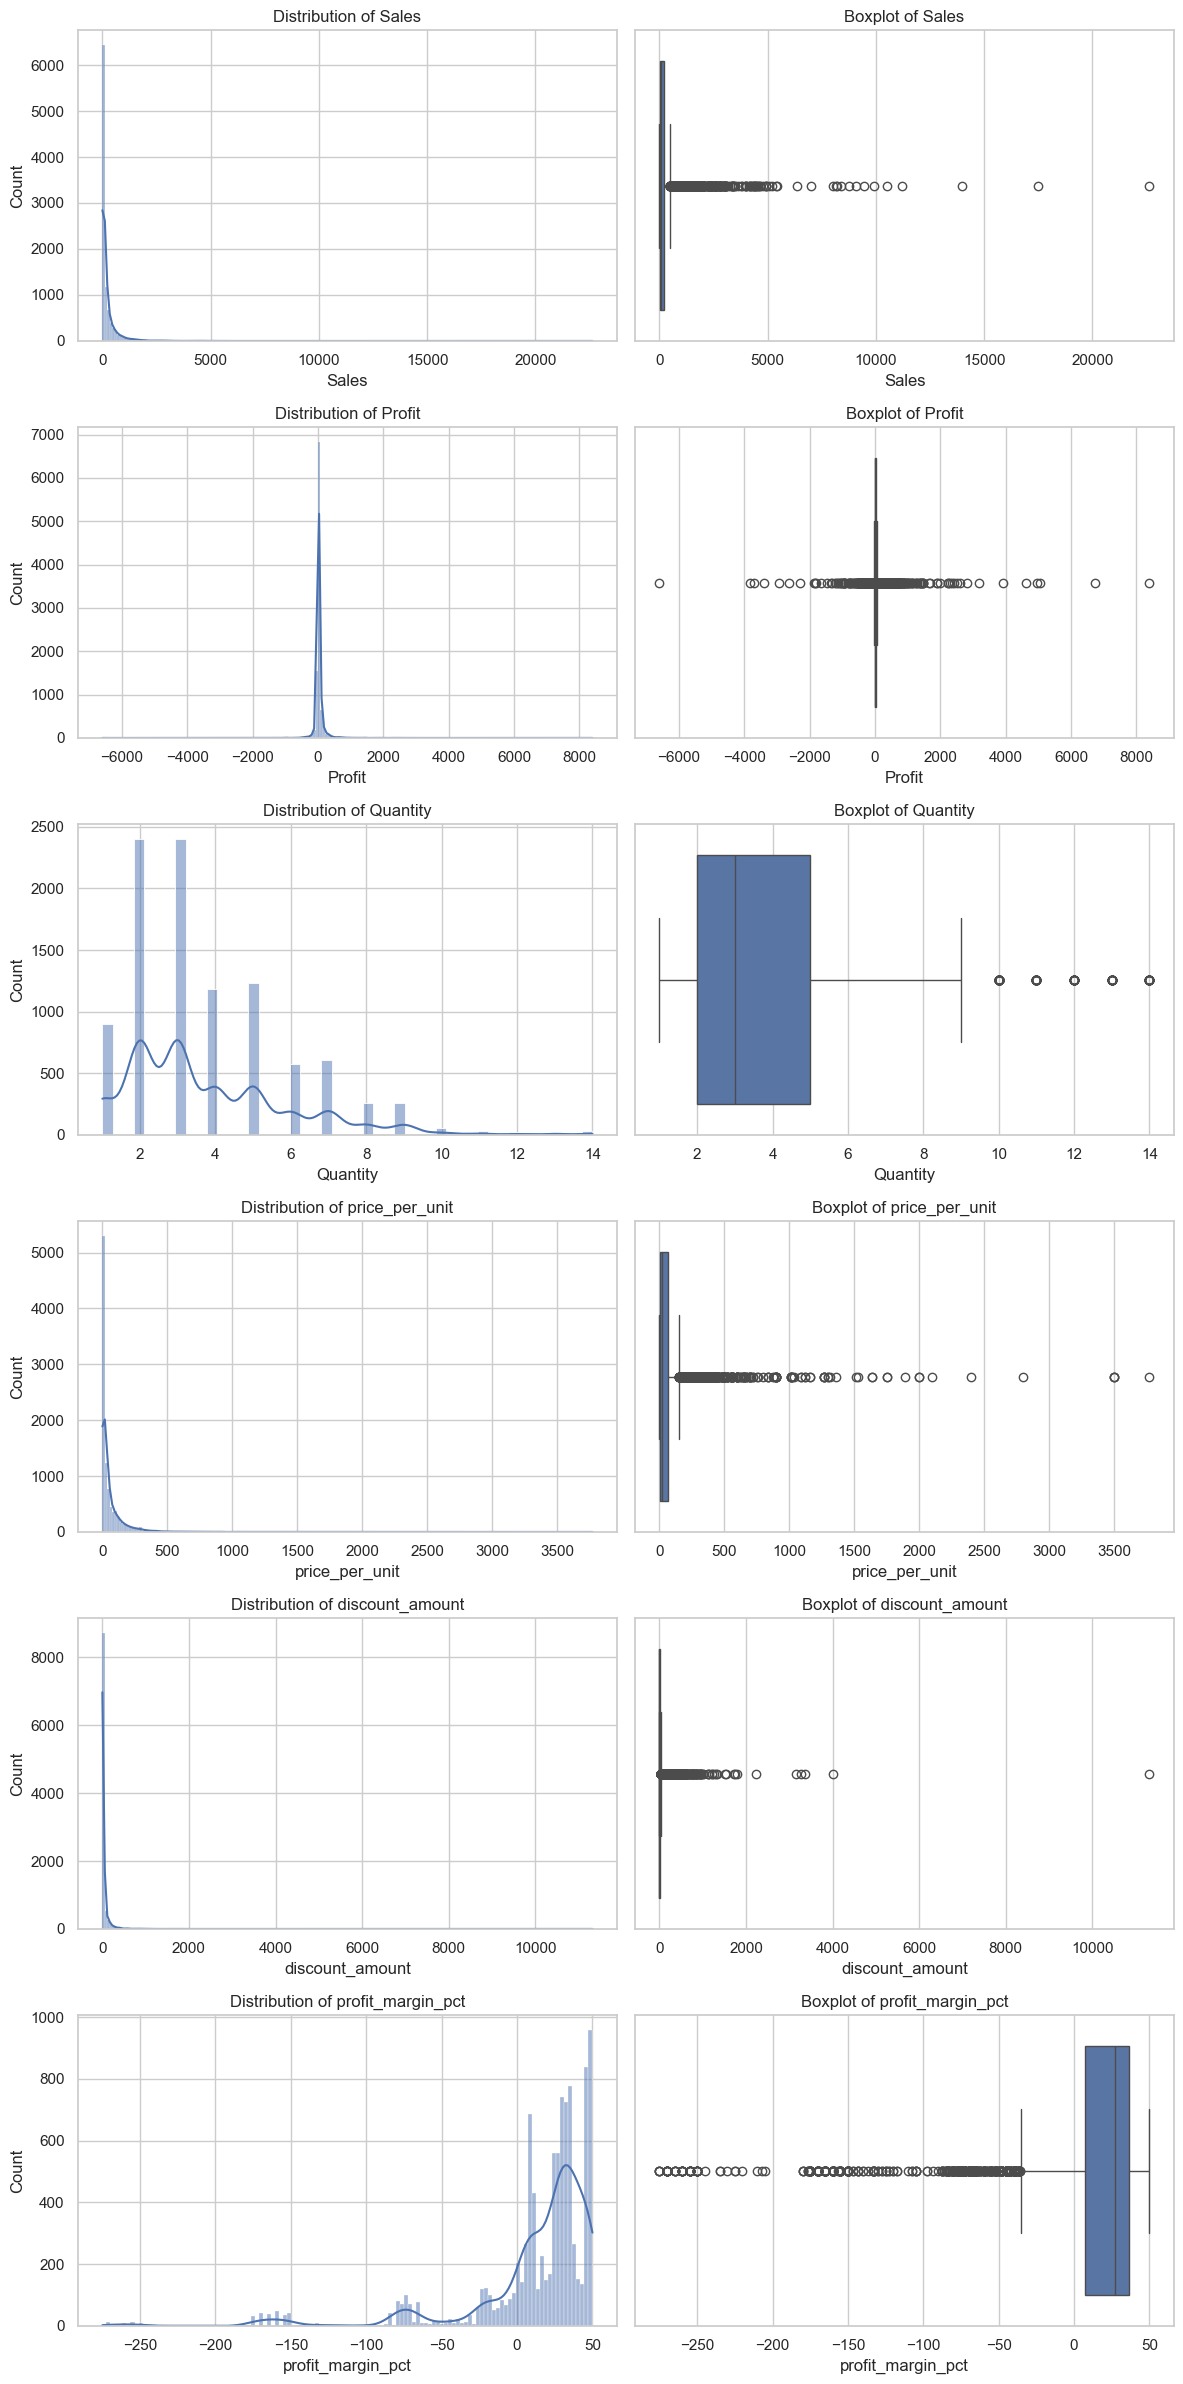

In [7]:
# Univariate distributions for key numeric fields
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
key_numeric = []
for name in [col_sales, col_profit, col_quantity, 'price_per_unit', 'discount_amount', 'profit_margin_pct']:
    if name and name in df.columns and name not in key_numeric:
        key_numeric.append(name)

n = len(key_numeric)
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
if n == 1:
    axes = np.array([axes])
for i, c in enumerate(key_numeric):
    sns.histplot(df[c].dropna(), kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {c}")
    sns.boxplot(x=df[c], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {c}")
plt.tight_layout()
plt.show()


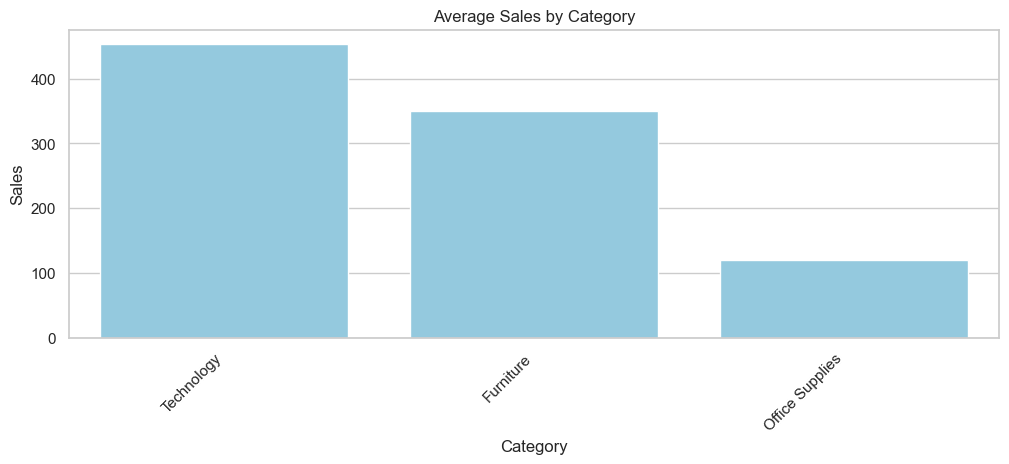

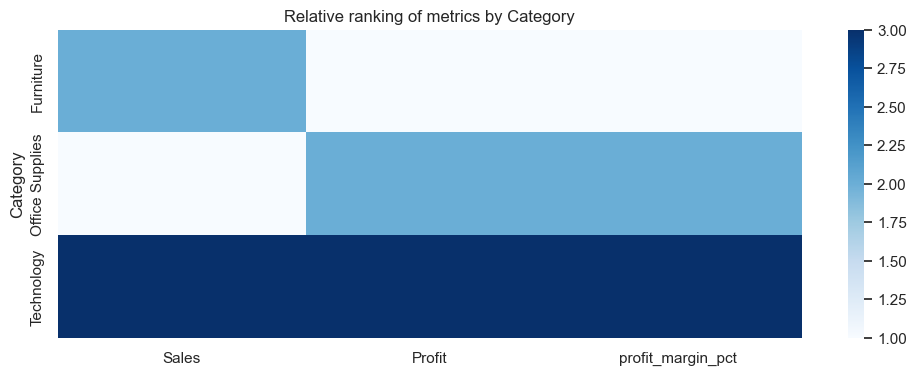

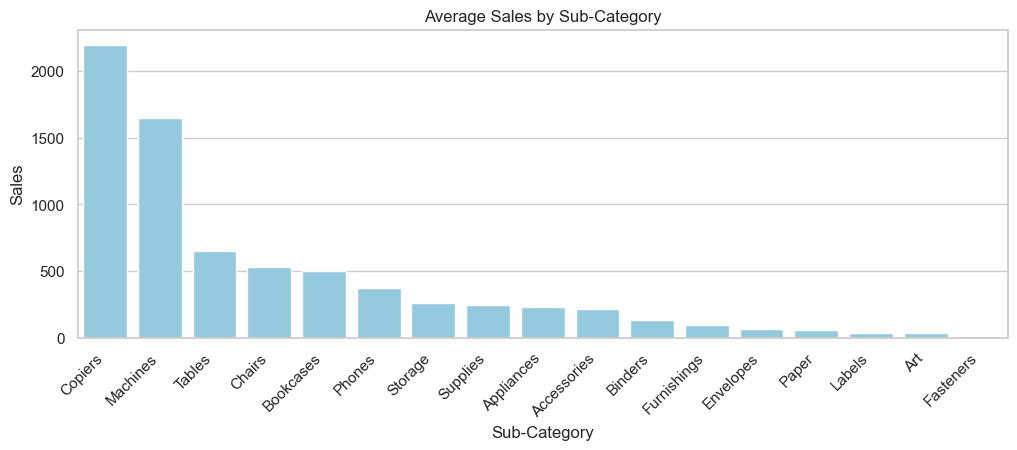

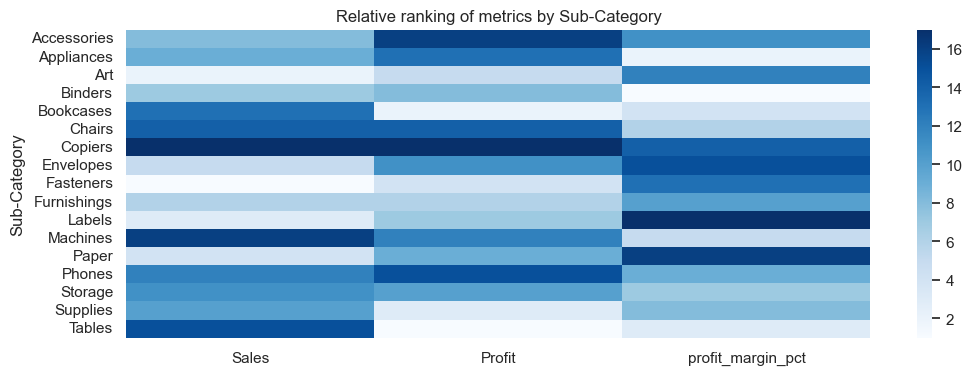

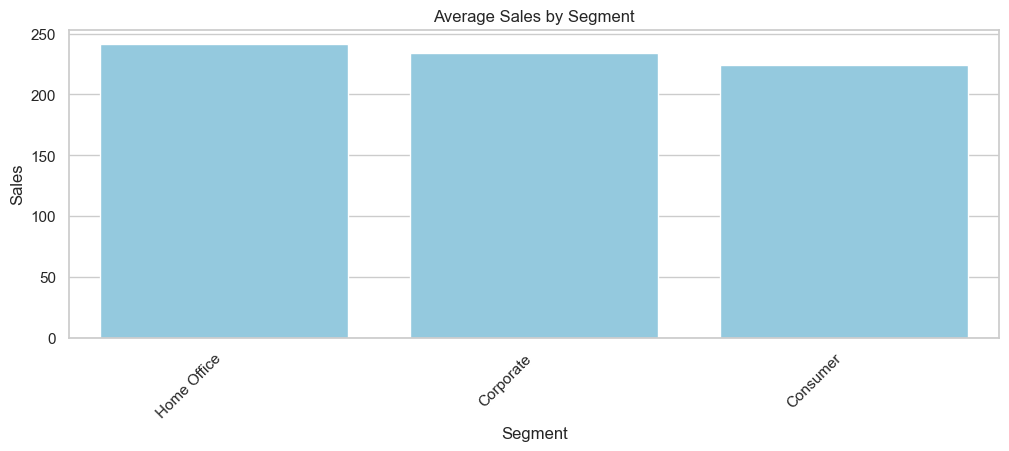

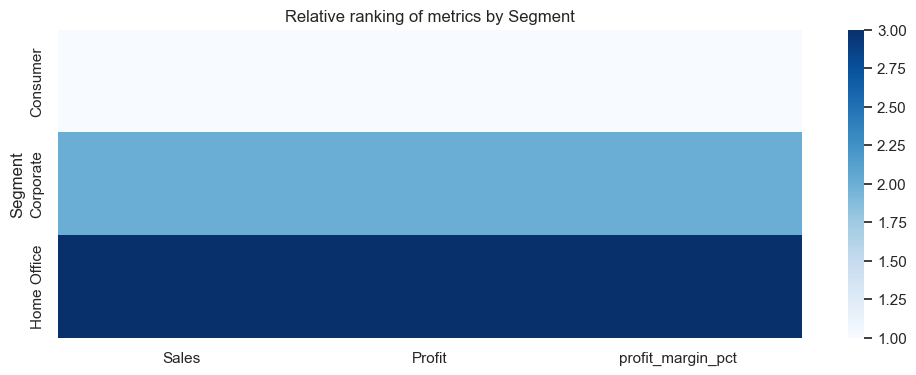

In [8]:
# Bivariate: relationships between sales/profit and categories

cat_cols_for_group = [c for c in [col_category, col_subcategory, col_segment, col_region, col_state, col_city] if c]
metrics = []
if col_sales: metrics.append(col_sales)
if col_profit: metrics.append(col_profit)
if 'profit_margin_pct' in df.columns: metrics.append('profit_margin_pct')

for cat_col in cat_cols_for_group[:3]:  # keep plots reasonable
    plt.figure(figsize=(12, 4))
    agg = df.groupby(cat_col)[metrics].mean().sort_values(by=metrics[0], ascending=False)
    sns.barplot(x=agg.index, y=agg[metrics[0]], color='skyblue')
    plt.title(f"Average {metrics[0]} by {cat_col}")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    if len(metrics) > 1:
        plt.figure(figsize=(12, 4))
        agg2 = df.groupby(cat_col)[metrics].mean()
        sns.heatmap(agg2.rank(axis=0, method='average'), cmap='Blues', annot=False, cbar=True)
        plt.title(f"Relative ranking of metrics by {cat_col}")
        plt.show()


In [9]:
# Time series trends: monthly sales and profit
if col_order_date and np.issubdtype(df[col_order_date].dtype, np.datetime64) and col_sales:
    ts = df.set_index(col_order_date).sort_index()
    monthly = ts.resample('MS').agg({col_sales:'sum'}).rename(columns={col_sales:'sales_sum'})
    if col_profit and pd.api.types.is_numeric_dtype(df[col_profit]):
        monthly['profit_sum'] = ts[col_profit].resample('MS').sum()

    monthly.plot(figsize=(12,5))
    plt.title('Monthly Sales and Profit')
    plt.ylabel('Amount')
    plt.show()

    # Seasonal heatmap by year-month
    pivot = ts.groupby([ts.index.year, ts.index.month])[col_sales].sum().unstack(fill_value=0)
    plt.figure(figsize=(12,5))
    sns.heatmap(pivot, cmap='YlGnBu', annot=False)
    plt.title('Sales Seasonality Heatmap (Year x Month)')
    plt.ylabel('Year'); plt.xlabel('Month')
    plt.show()


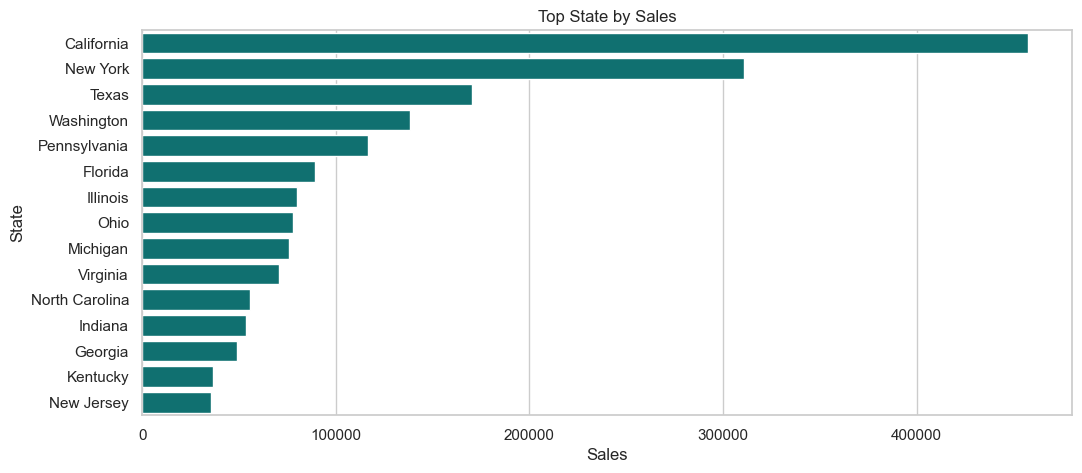

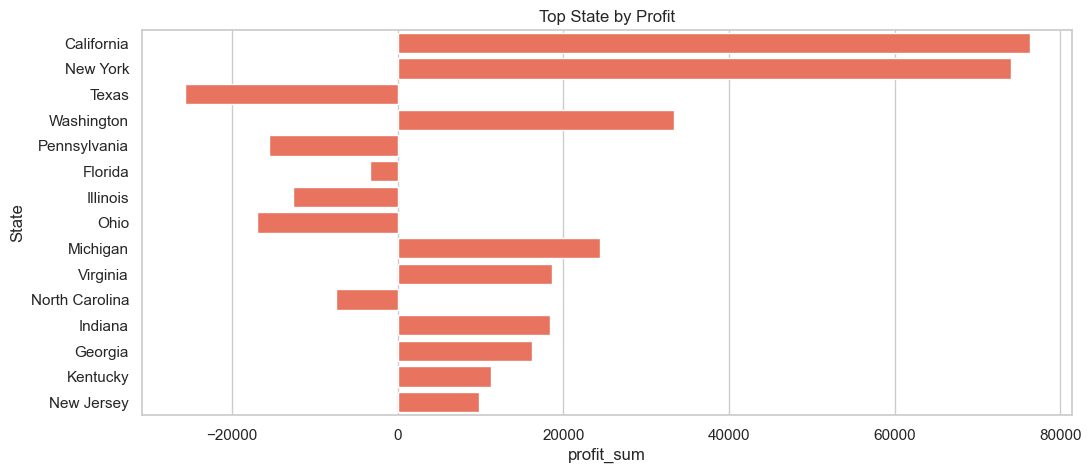

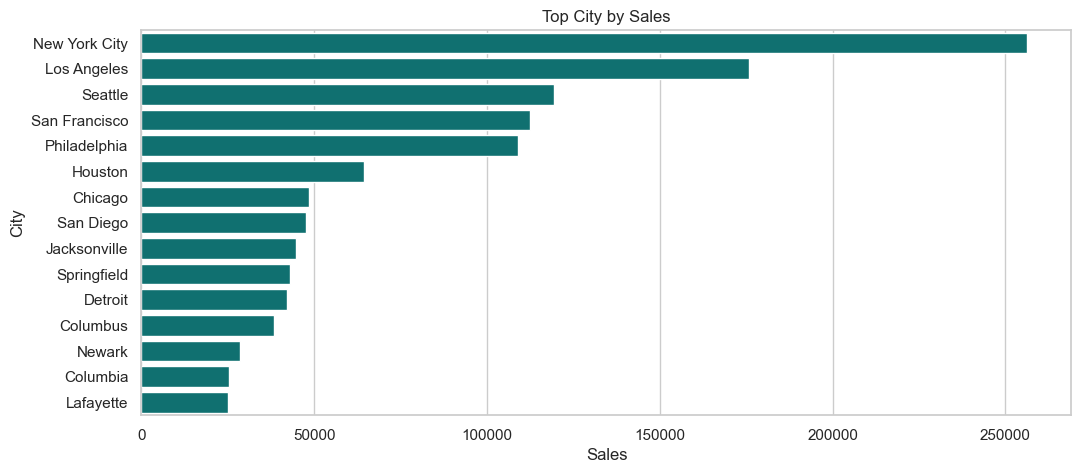

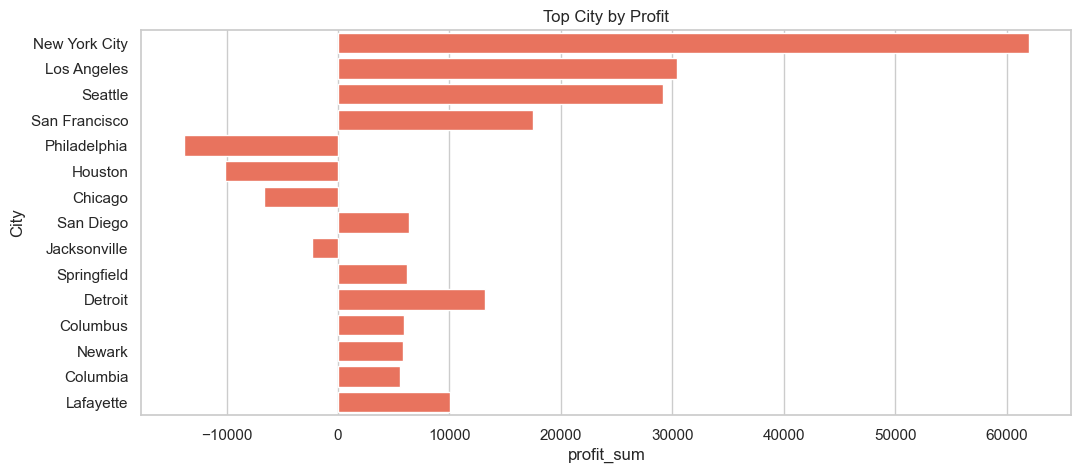

In [10]:
# Geography (if available): top states/cities by sales and profit
if col_state or col_city:
    for geo_col in [col_state, col_city]:
        if not geo_col:
            continue
        topn = df.groupby(geo_col).agg({col_sales:'sum', col_profit:'sum' if col_profit else col_sales}).sort_values(by=col_sales, ascending=False).head(15)
        topn = topn.rename(columns={col_profit: 'profit_sum' if col_profit else 'proxy'})
        plt.figure(figsize=(12,5))
        sns.barplot(y=topn.index, x=topn[col_sales], orient='h', color='teal')
        plt.title(f'Top {geo_col} by Sales')
        plt.show()
        if col_profit:
            plt.figure(figsize=(12,5))
            sns.barplot(y=topn.index, x=topn['profit_sum'], orient='h', color='tomato')
            plt.title(f'Top {geo_col} by Profit')
            plt.show()


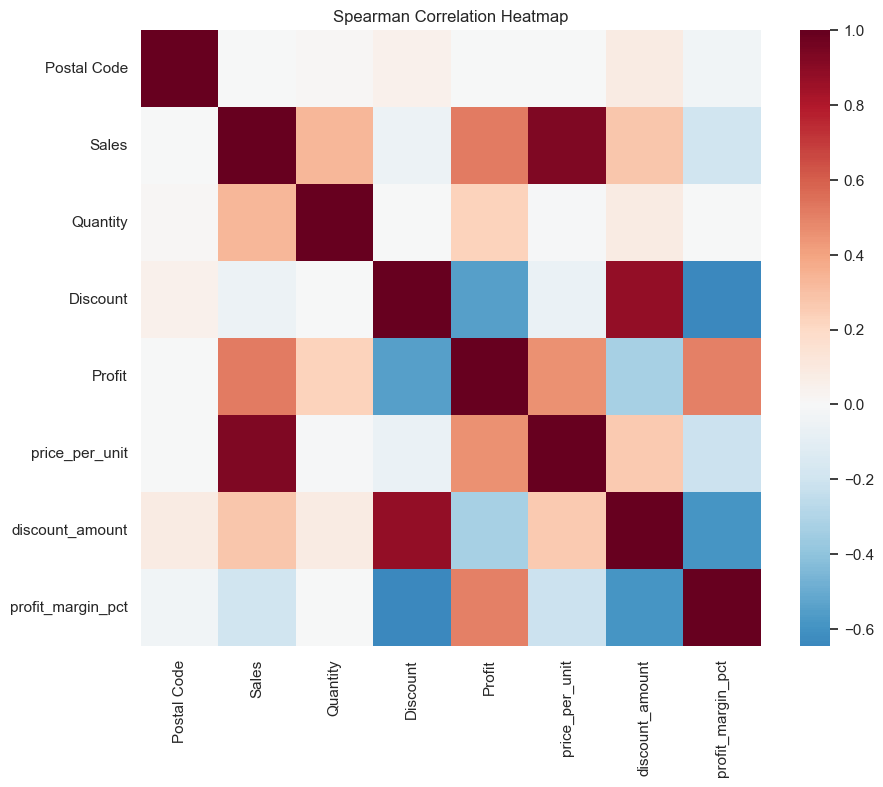

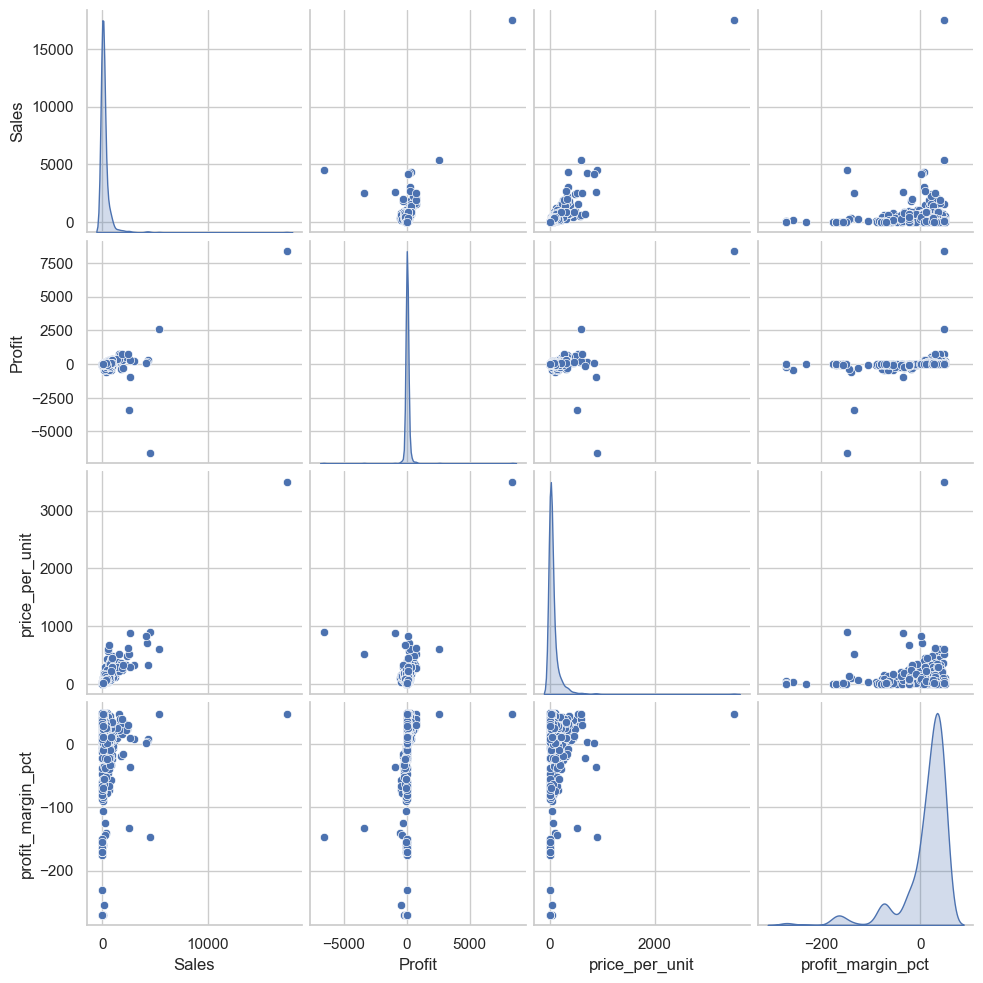

In [11]:
# Correlation heatmap for numeric variables
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(method='spearman')
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='RdBu_r', center=0)
    plt.title('Spearman Correlation Heatmap')
    plt.show()

# Pairwise scatter for selected metrics
pair_cols = [c for c in [col_sales, col_profit, 'price_per_unit', 'profit_margin_pct'] if c in df.columns]
if len(pair_cols) >= 2:
    sns.pairplot(df[pair_cols].sample(min(1000, len(df))), diag_kind='kde')
    plt.show()


In [12]:
# RFM Analysis (Recency, Frequency, Monetary) at customer level
if col_customer and col_sales and col_order_date and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    rfm_ref = rfm_reference_date or (df[col_order_date].max() + pd.Timedelta(days=1))
    cust_group = df.groupby(col_customer)
    rfm = pd.DataFrame({
        'recency_days': cust_group[col_order_date].max().rsub(rfm_ref).dt.days * -1,
        'frequency': cust_group.size(),
        'monetary': cust_group[col_sales].sum(),
    })
    # Score 1-5
    r_labels = [5,4,3,2,1]  # lower recency -> higher score
    r_bins = pd.qcut(rfm['recency_days'], 5, labels=r_labels)
    f_bins = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
    m_bins = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])
    rfm['R'], rfm['F'], rfm['M'] = r_bins.astype(int), f_bins.astype(int), m_bins.astype(int)
    rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

    plt.figure(figsize=(10,4))
    sns.histplot(rfm['RFM_Score'], bins=15, kde=False)
    plt.title('Distribution of RFM Scores')
    plt.show()

    top_customers = rfm.sort_values('RFM_Score', ascending=False).head(10)
    display(top_customers)


In [13]:
# Simple cohort analysis by monthly acquisition
if col_customer and col_order_date and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    temp = df[[col_customer, col_order_date]].copy()
    temp['order_month'] = temp[col_order_date].values.astype('datetime64[M]')
    first_purchase = temp.groupby(col_customer)['order_month'].min().rename('cohort')
    temp = temp.join(first_purchase, on=col_customer)
    temp['period_number'] = ((temp['order_month'].dt.year - temp['cohort'].dt.year) * 12 + (temp['order_month'].dt.month - temp['cohort'].dt.month))

    cohort_pivot = temp.pivot_table(index='cohort', columns='period_number', values=col_customer, aggfunc=pd.Series.nunique)
    cohort_retention = cohort_pivot.divide(cohort_pivot.iloc[:,0], axis=0)

    plt.figure(figsize=(12,5))
    sns.heatmap(cohort_retention, cmap='YlOrBr', annot=False, fmt='.0%', cbar=True)
    plt.title('Cohort Retention (Unique Customers)')
    plt.ylabel('Cohort (Acquisition Month)')
    plt.xlabel('Months since first purchase')
    plt.show()


## Conclusions

- Sales and profitability distributions highlight key ranges and outliers.
- Category/segment/region breakdowns reveal where value is concentrated.
- Time series shows seasonality and growth/decline phases.
- RFM segments help identify loyal/high-value customers.
- Cohort retention provides customer stickiness insight.

You can extend this notebook by:
- Adding forecasting (e.g., Prophet) if time series is robust.
- Including geospatial maps if latitude/longitude are available.
- Building simple models to predict profitability or churn propensity.


### Notes
- The notebook auto-detects a dataset in the working directory. If it picks the wrong file, set `chosen = Path('your_file.csv')` manually in the imports cell before loading.
- If your Excel has multiple sheets, adjust the `sheet_name` when reading.
- All visualizations are built with `seaborn` and `matplotlib`. Customize palettes and contexts as needed.
- Feature engineering depends on the presence of columns like `Sales`, `Profit`, `Quantity`, `Discount`, `Order Date`, `Customer Name`. If your dataset uses different names, update the mapping logic in the feature engineering cell.


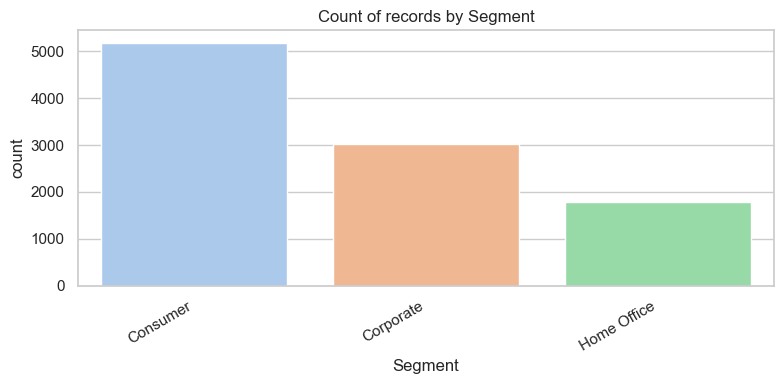

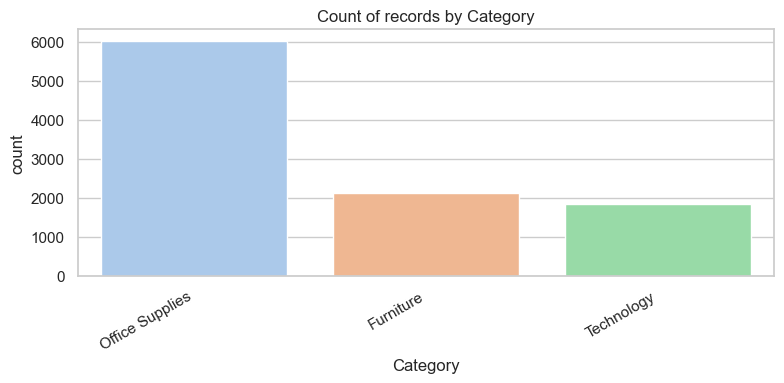

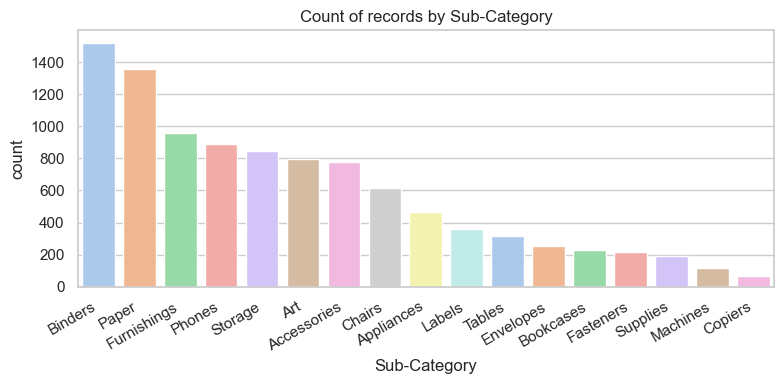

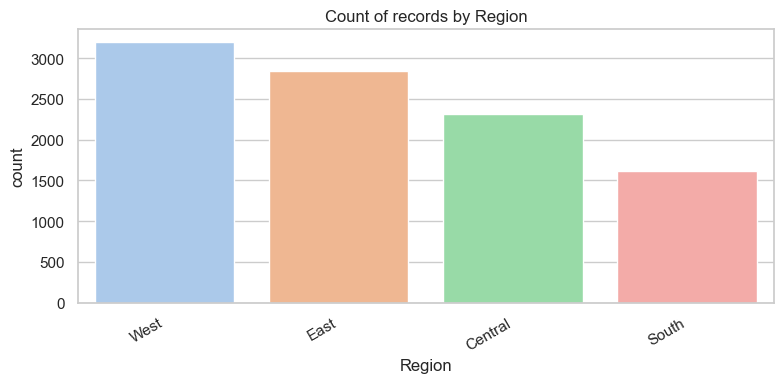

In [14]:
# Additional simple categorical distributions
_cat_targets = [col_segment, col_category, col_subcategory, col_region]
for c in [x for x in _cat_targets if x]:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=c, order=df[c].value_counts().index, palette='pastel')
    plt.title(f'Count of records by {c}')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


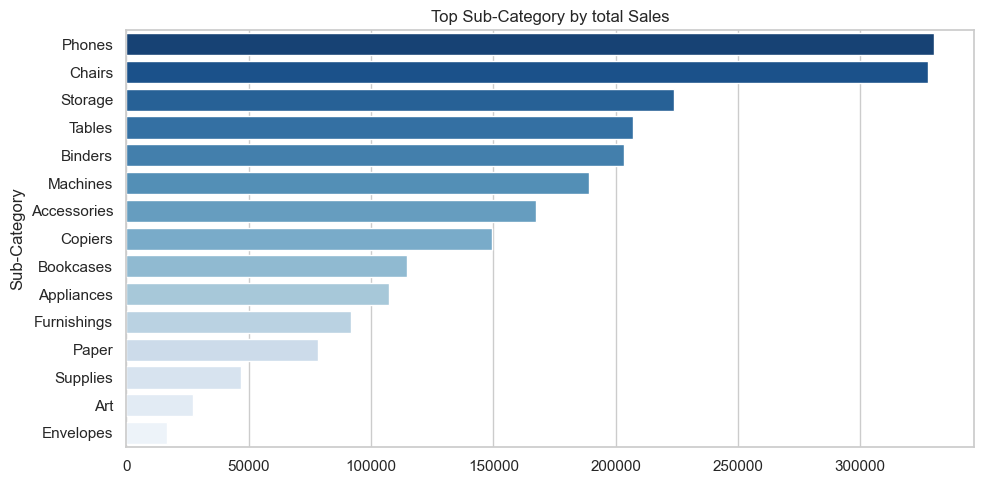

In [15]:
# Top-N rankings: products/subcategories by total sales
rank_col = col_subcategory or col_category
if col_sales and rank_col:
    top = df.groupby(rank_col)[col_sales].sum().sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    sns.barplot(y=top.index, x=top.values, orient='h', palette='Blues_r')
    plt.title(f'Top {rank_col} by total {col_sales}')
    plt.tight_layout()
    plt.show()


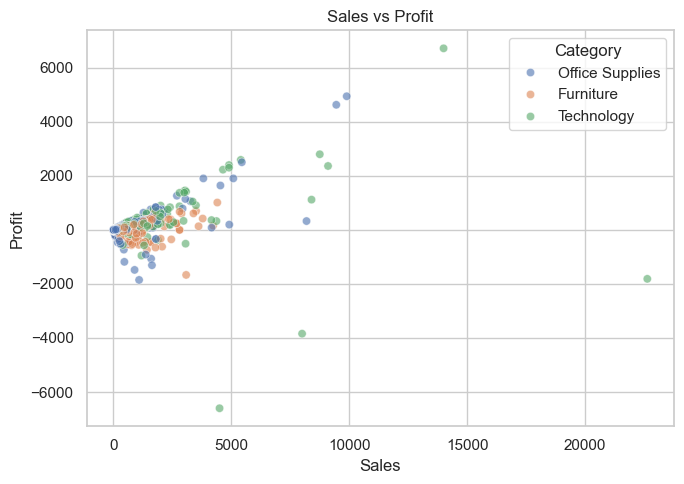

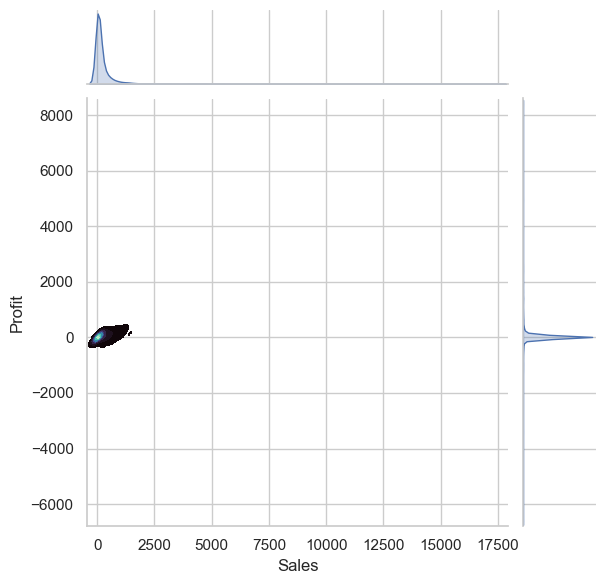

In [16]:
# Scatter/Jitter: Sales vs Profit
if col_sales and col_profit:
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df.sample(min(5000, len(df))), x=col_sales, y=col_profit, hue=col_category if col_category else None, alpha=0.6)
    plt.title('Sales vs Profit')
    plt.tight_layout()
    plt.show()

    # Jointplot (kde)
    sns.jointplot(data=df.sample(min(4000, len(df))), x=col_sales, y=col_profit, kind='kde', fill=True, cmap='mako')
    plt.show()


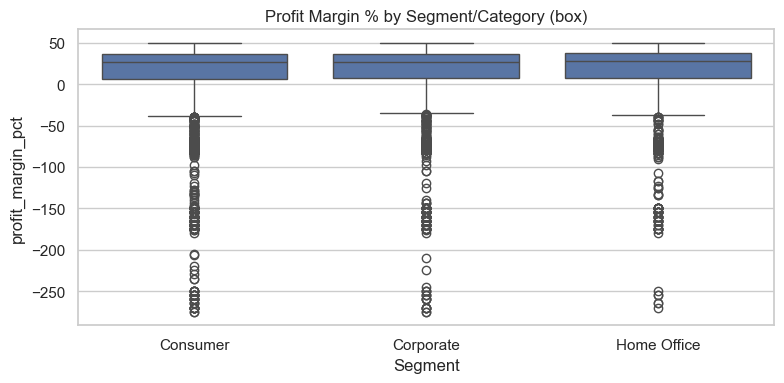

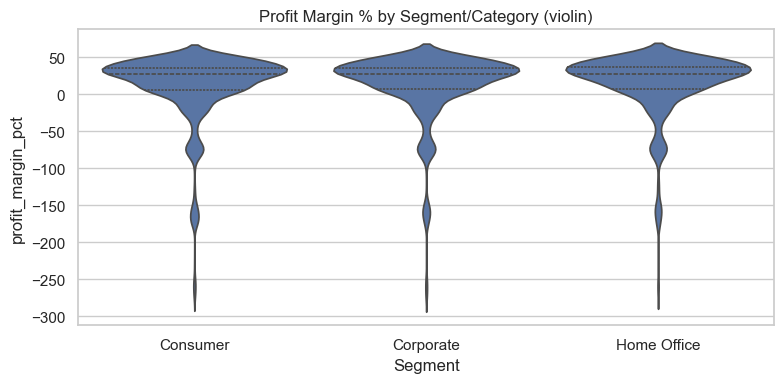

In [17]:
# Box/Violin plots: Profit margin by segment/category
if 'profit_margin_pct' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x=col_segment if col_segment else col_category, y='profit_margin_pct')
    plt.title('Profit Margin % by Segment/Category (box)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    sns.violinplot(data=df, x=col_segment if col_segment else col_category, y='profit_margin_pct', inner='quartile')
    plt.title('Profit Margin % by Segment/Category (violin)')
    plt.tight_layout()
    plt.show()


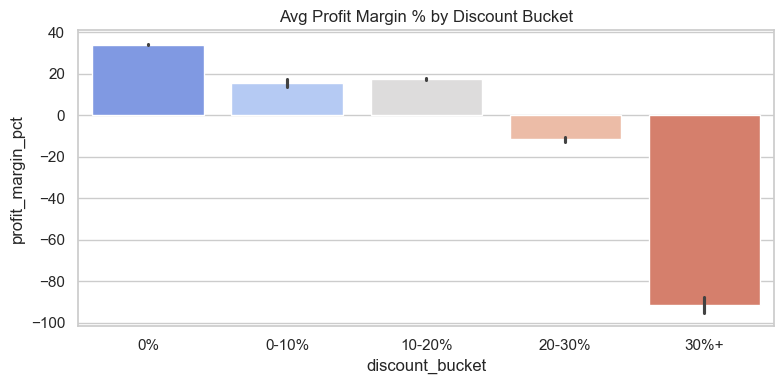

In [18]:
# Discount buckets vs profitability
if col_discount and 'profit_margin_pct' in df.columns:
    bins = [-0.01, 0.0, 0.1, 0.2, 0.3, 1.0]
    labels = ['0%', '0-10%', '10-20%', '20-30%', '30%+']
    df['discount_bucket'] = pd.cut(df[col_discount].clip(lower=0, upper=1), bins=bins, labels=labels)
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x='discount_bucket', y='profit_margin_pct', estimator=np.mean, palette='coolwarm')
    plt.title('Avg Profit Margin % by Discount Bucket')
    plt.tight_layout()
    plt.show()


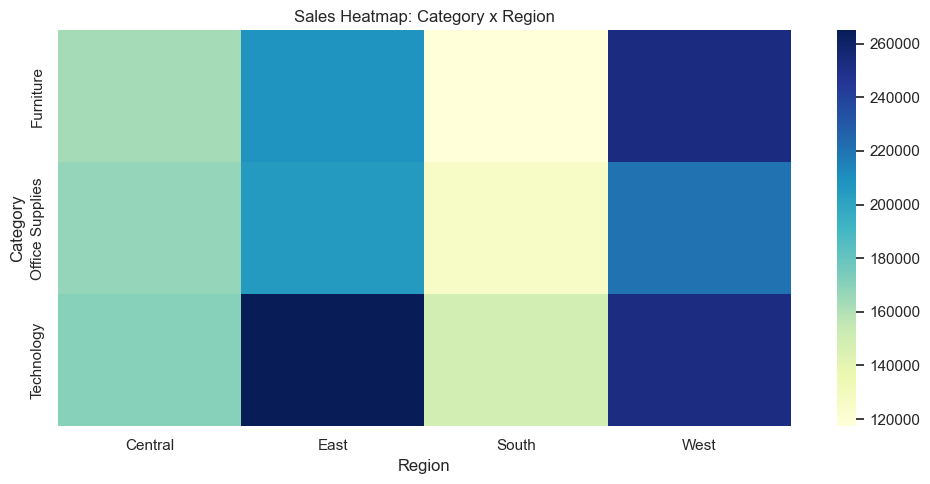

In [19]:
# Pivot heatmap: Category x Region sales
if col_category and col_region and col_sales:
    pivot = df.pivot_table(values=col_sales, index=col_category, columns=col_region, aggfunc='sum', fill_value=0)
    plt.figure(figsize=(10,5))
    sns.heatmap(pivot, cmap='YlGnBu')
    plt.title('Sales Heatmap: Category x Region')
    plt.tight_layout()
    plt.show()


In [20]:
# Weekday and hour-of-day sales (if timestamp has time)
if col_order_date and np.issubdtype(df[col_order_date].dtype, np.datetime64) and col_sales:
    df['weekday'] = df[col_order_date].dt.day_name()
    order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    plt.figure(figsize=(8,4))
    sns.barplot(data=df, x='weekday', y=col_sales, estimator=np.sum, order=order, palette='crest')
    plt.title('Total Sales by Weekday')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    if hasattr(df[col_order_date].dt, 'hour'):
        df['hour'] = df[col_order_date].dt.hour
        plt.figure(figsize=(8,4))
        sns.lineplot(data=df, x='hour', y=col_sales, estimator=np.mean, errorbar=None)
        plt.title('Avg Sales by Hour of Day')
        plt.tight_layout()
        plt.show()


In [21]:
# Stacked area by category over time (monthly)
if col_order_date and col_category and col_sales and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    mdf = df.copy()
    mdf['ym'] = mdf[col_order_date].dt.to_period('M').dt.to_timestamp()
    pv = mdf.pivot_table(values=col_sales, index='ym', columns=col_category, aggfunc='sum').fillna(0)
    pv.sort_index(inplace=True)
    pv.plot.area(figsize=(12,6), colormap='tab20')
    plt.title('Monthly Sales by Category (stacked area)')
    plt.ylabel('Sales')
    plt.tight_layout()
    plt.show()


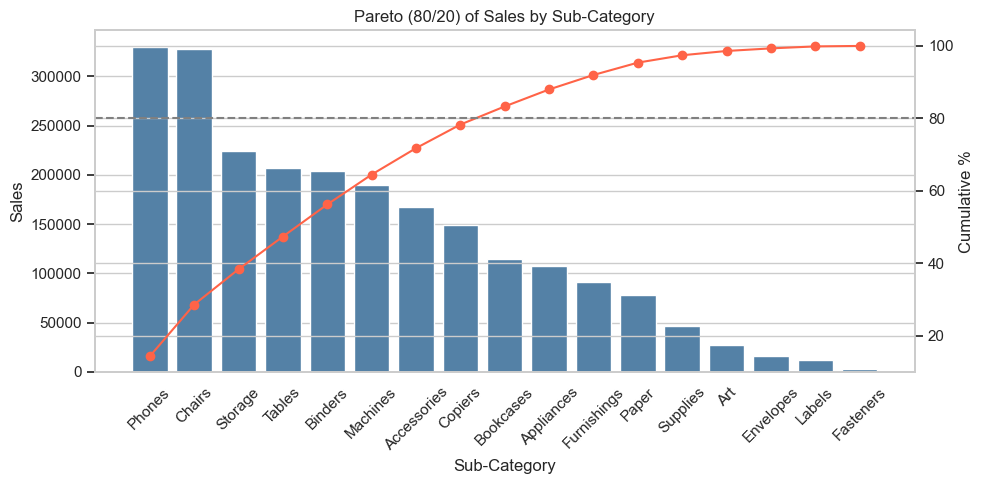

In [22]:
# Pareto chart: cumulative sales contribution by subcategory
if col_sales and (col_subcategory or col_category):
    key = col_subcategory or col_category
    contrib = df.groupby(key)[col_sales].sum().sort_values(ascending=False)
    cum_pct = contrib.cumsum() / contrib.sum() * 100
    fig, ax1 = plt.subplots(figsize=(10,5))
    sns.barplot(x=contrib.index, y=contrib.values, color='steelblue', ax=ax1)
    ax1.set_xlabel(key); ax1.set_ylabel('Sales')
    ax1.tick_params(axis='x', rotation=45)
    ax2 = ax1.twinx()
    ax2.plot(range(len(contrib)), cum_pct.values, color='tomato', marker='o')
    ax2.set_ylabel('Cumulative %')
    ax2.axhline(80, color='gray', linestyle='--')
    plt.title('Pareto (80/20) of Sales by '+key)
    plt.tight_layout()
    plt.show()


In [23]:
# Average order value (AOV) trend
if col_order_date and col_sales and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    tmp = df.copy()
    tmp['ym'] = tmp[col_order_date].dt.to_period('M').dt.to_timestamp()
    orders_per_month = tmp.groupby('ym').size()
    sales_per_month = tmp.groupby('ym')[col_sales].sum()
    aov = (sales_per_month / orders_per_month).rename('AOV')
    plt.figure(figsize=(10,4))
    aov.plot(marker='o')
    plt.title('Average Order Value by Month')
    plt.ylabel('AOV')
    plt.tight_layout()
    plt.show()


In [24]:
# Operational: Ship delay distribution (if ship date available)
if col_ship_date and col_order_date and np.issubdtype(df[col_ship_date].dtype, np.datetime64) and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    ship_delay = (df[col_ship_date] - df[col_order_date]).dt.days
    plt.figure(figsize=(8,4))
    sns.histplot(ship_delay, bins=30, kde=True)
    plt.title('Shipping Delay (days) Distribution')
    plt.tight_layout()
    plt.show()

    if col_segment:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=df[col_segment], y=ship_delay)
        plt.title('Shipping Delay by Segment')
        plt.tight_layout()
        plt.show()


In [25]:
# Category share over time (percentage stacked)
if col_order_date and col_category and col_sales and np.issubdtype(df[col_order_date].dtype, np.datetime64):
    mdf = df.copy()
    mdf['ym'] = mdf[col_order_date].dt.to_period('M').dt.to_timestamp()
    pv = mdf.pivot_table(values=col_sales, index='ym', columns=col_category, aggfunc='sum').fillna(0)
    share = pv.div(pv.sum(axis=1), axis=0)
    share.plot.area(figsize=(12,6), colormap='tab20')
    plt.title('Category Sales Share by Month')
    plt.ylabel('Share')
    plt.tight_layout()
    plt.show()


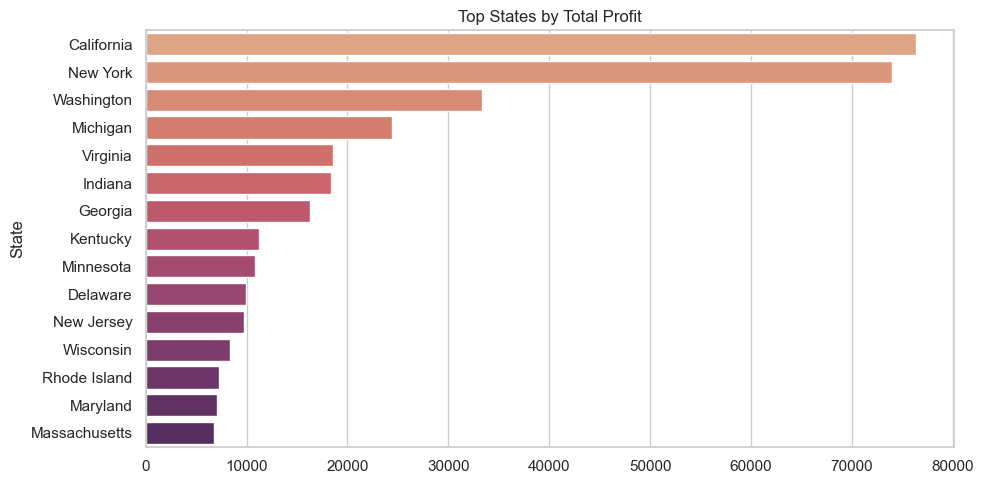

In [26]:
# Profitability by state (if state is present)
if col_state and col_profit:
    top_profit = df.groupby(col_state)[col_profit].sum().sort_values(ascending=False).head(15)
    plt.figure(figsize=(10,5))
    sns.barplot(y=top_profit.index, x=top_profit.values, orient='h', palette='flare')
    plt.title('Top States by Total Profit')
    plt.tight_layout()
    plt.show()


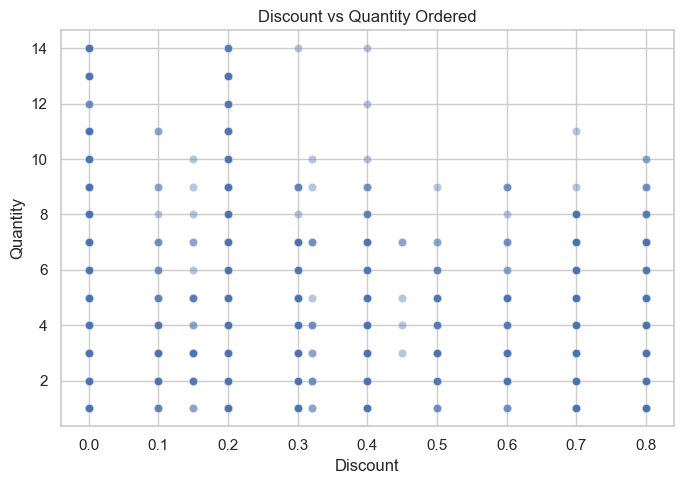

In [27]:
# Quantity vs Discount relationship
if col_quantity and col_discount:
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=df.sample(min(5000, len(df))), x=col_discount, y=col_quantity, alpha=0.4)
    plt.title('Discount vs Quantity Ordered')
    plt.tight_layout()
    plt.show()
